# **Game Play Time Series Forecasting - Kaggle**
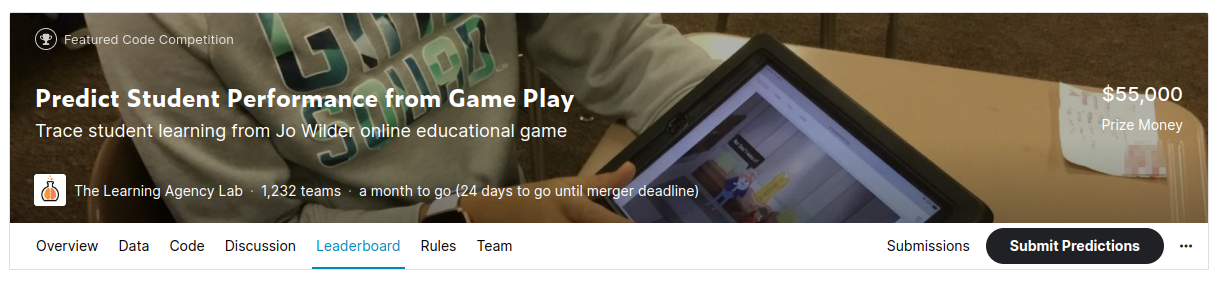
><pre>
@misc{predict-student-performance-from-game-play,
    author = {Alex Franklin, David Gagnon, HCL-Jevster, Maggie, Meg Benner, Natalie Rambis, Perpetual Baffour, Scott Crossley, ulrichboser},
    title = {Predict Student Performance from Game Play},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/predict-student-performance-from-game-play}
}
</pre>

In [1]:
!pip3 install watermark --quiet
%load_ext watermark
%watermark -a 'NavinKumarMNK' -v -p polars,plotly,optuna,catboost,lightgbm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Author: NavinKumarMNK

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.12.0

polars  : 0.17.5
plotly  : 5.14.1
optuna  : 3.1.1
catboost: 1.1.1
lightgbm: 3.3.2



## **Modules Import & Setup**

In [2]:
import polars as pl
import pandas as pd
import optuna 
import os
import gc
import catboost as cb
import lightgbm as lgb
import plotly.express as px
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/gameplay/sample_submission.csv
/kaggle/input/gameplay/train.parquet
/kaggle/input/gameplay/train_labels.csv
/kaggle/input/gameplay/test.csv
/kaggle/input/gameplay/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/gameplay/jo_wilder_310/__init__.py
/kaggle/input/gameplay/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/gameplay/jo_wilder/__init__.py


## **Dataset**

In [4]:
train_data_path = '/kaggle/input/gameplay/train.csv'
test_data_path = '/kaggle/input/gameplay/test.csv'
submission_data_path = '/kaggle/input/gameplay/sample_submission.csv'
workspace_path = '/kaggle/input/gameplay/'
labels_path = '/kaggle/input/gameplay/train_labels.csv'

In [5]:
'''
# Run only once
# convert csv to parquet using pyarrow
import pyarrow.csv as pv
import pyarrow.parquet as pq

filename = train_data_path
table = pv.read_csv(filename)
pq.write_table(table, filename.replace('csv', 'parquet'), row_group_size=1000000)
'''

"\n# Run only once\n# convert csv to parquet using pyarrow\nimport pyarrow.csv as pv\nimport pyarrow.parquet as pq\n\nfilename = train_data_path\ntable = pv.read_csv(filename)\npq.write_table(table, filename.replace('csv', 'parquet'), row_group_size=1000000)\n"

In [6]:
train_df_par = pl.read_parquet(train_data_path.replace('csv', 'parquet'))
print(train_df_par.shape)
print(train_df_par.n_chunks())
train_df_par.head()

(26296946, 20)
27


session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
i64,i64,i64,str,str,i64,f64,f64,f64,f64,f64,f64,str,str,str,str,i64,i64,i64,str
20090312431273200,0,0,"""cutscene_click…","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,2,831,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""


In [7]:
COLUMNS = []
for col in train_df_par.columns:
    COLUMNS.append(col)
    print(col, train_df_par[col].n_unique())

session_id 23562
index 20348
elapsed_time 5042639
event_name 11
name 6
level 23
page 8
room_coor_x 17441451
room_coor_y 13653975
screen_coor_x 57925
screen_coor_y 102592
hover_duration 24102
text 598
fqid 129
room_fqid 19
text_fqid 127
fullscreen 2
hq 2
music 2
level_group 3


In [8]:
# visualize index distribution
px.line(
        train_df_par['index'].value_counts().sort('index').to_pandas()['counts'], 
        title='Index Distribution', labels={'index': 'Index', 'value': 'Count'},
        width=800, height=400
)

In [9]:
# visualize session_id distribution
px.line(y=train_df_par['session_id'].value_counts().sort('session_id').to_pandas()['counts'],
        x=train_df_par['session_id'].value_counts().sort('session_id').to_pandas()['session_id'],
        title='Session ID Distribution', labels={'x': 'Session ID', 'y': 'Count'},
        width=800, height=400
)

- Session ID = [YY][MM][ID]
- Concentrated on 2020st september, 2021 July, 2022 July

In [10]:
columns = [
    pl.col("page").cast(pl.Int8),
    pl.col("level").cast(pl.Int8),
    pl.col("fullscreen").cast(pl.Int8),
    pl.col("hq").cast(pl.Int8),
    pl.col("music").cast(pl.Int8),
    pl.col("index").cast(pl.UInt16),
    (
        pl.when(pl.col("hover_duration").is_null())
        .then(0)
        .otherwise(1)
        .alias("is_hover")
        .cast(pl.Int8)
    ),
    (
        pl.when(pl.col("room_coor_x").is_null())
        .then(0)
        .otherwise(1)
        .alias("is_click")
        .cast(pl.Int8)
    ),
    (
        pl.when(pl.col("page").is_null())
        .then(0)
        .otherwise(1)
        .alias("is_page")
        .cast(pl.Int8)
    ),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(-1e9, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("screen_corr_x_dff")
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("screen_corr_y_dff")
    ),
    (
        (pl.col("room_coor_x") - pl.col("room_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("room_corr_x_diff")
    ),
    (
        (pl.col("room_coor_y") - pl.col("room_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("room_corr_y_diff")
    )
]

In [11]:
df = (train_df_par.with_columns(columns))
df.head()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,is_hover,is_click,is_page,elapsed_time_diff,screen_corr_x_dff,screen_corr_y_dff,room_corr_x_diff,room_corr_y_diff
i64,u16,i64,str,str,i8,i8,f64,f64,f64,f64,f64,str,str,str,str,i8,i8,i8,str,i8,i8,i8,i64,f64,f64,f64,f64
20090312431273200,0,0,"""cutscene_click…","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,0,null,null,null,null
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,1323,0.0,0.0,0.0,0.0
20090312431273200,2,831,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,-492,0.0,0.0,0.0,0.0
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,316,0.0,0.0,0.0,0.0
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,716,1.0,0.0,1.0,0.0


In [12]:
df = df.with_columns([
    pl.col('fqid').apply(lambda x: 'fqid_None' if x == '' else x).alias('fqid'),
])
df.filter(pl.col('fqid') == '').shape[0]

0

In [13]:
df = df.with_columns([
    pl.col('text_fqid').apply(lambda x: 'text_fqid_None' if x == '' else x).alias('text_fqid'),
])
df.filter(pl.col('text_fqid') == '').shape[0]

0

In [14]:
df = df.with_columns([
    pl.col('page').fill_null(-1),
])
df.null_count()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,is_hover,is_click,is_page,elapsed_time_diff,screen_corr_x_dff,screen_corr_y_dff,room_corr_x_diff,room_corr_y_diff
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,2073272,2073272,2073272,2073272,24294702,0,0,0,0,0,0,0,0,0,0,0,0,3773981,3773981,3773981,3773981


In [15]:
columns = [
    pl.col('session_id').apply(lambda x: int(str(x)[:2])).cast(pl.Int8).alias('year'),
    pl.col('session_id').apply(lambda x: int(str(x)[2:4])+1).cast(pl.Int8).alias('month'),
    pl.col('session_id').apply(lambda x: int(str(x)[4:6])).cast(pl.Int8).alias('day'),
    pl.col('session_id').apply(lambda x: int(str(x)[6:8])).cast(pl.Int8).alias('hour'),
    pl.col('session_id').apply(lambda x: int(str(x)[8:10])).cast(pl.Int8).alias('minute'),
    pl.col('session_id').apply(lambda x: int(str(x)[10:12])).cast(pl.Int8).alias('second'),
]

df = df.with_columns(columns)
df.head()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,is_hover,is_click,is_page,elapsed_time_diff,screen_corr_x_dff,screen_corr_y_dff,room_corr_x_diff,room_corr_y_diff,year,month,day,hour,minute,second
i64,u16,i64,str,str,i8,i8,f64,f64,f64,f64,f64,str,str,str,str,i8,i8,i8,str,i8,i8,i8,i64,f64,f64,f64,f64,i8,i8,i8,i8,i8,i8
20090312431273200,0,0,"""cutscene_click…","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,0,null,null,null,null,20,10,3,12,43,12
20090312431273200,1,1323,"""person_click""","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,1323,0.0,0.0,0.0,0.0,20,10,3,12,43,12
20090312431273200,2,831,"""person_click""","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,-492,0.0,0.0,0.0,0.0,20,10,3,12,43,12
20090312431273200,3,1147,"""person_click""","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,316,0.0,0.0,0.0,0.0,20,10,3,12,43,12
20090312431273200,4,1863,"""person_click""","""basic""",0,-1,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,716,1.0,0.0,1.0,0.0,20,10,3,12,43,12


In [22]:
lower = df["elapsed_time_diff"].quantile(0.1)
upper = df["elapsed_time_diff"].quantile(0.9)

px.line(
    df.filter((pl.col("elapsed_time_diff") > lower) 
              & (pl.col("elapsed_time_diff") < upper))['elapsed_time_diff']
    .value_counts()
    .sort('elapsed_time_diff')
    .to_pandas()['counts'],
    title="Elapsed Time DIff Distribution", 
    labels={
        'index' : 'Elapsed Time Diff',
        'value' : 'Count'
    }
)

### **Feature List**

In [ ]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid',] 
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 
        'screen_coor_y', 'hover_duration', 'elapsed_time_diff']
SNO = ['session_id', 'index']
LEVEL = {
    '0-4'  : [0, 1, 2, 3, 4],
    '5-12' : [5, 6, 7, 8, 9, 10, 11, 12],
    '13-22': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
}
DUO = ['fullscreen', 'hq', 'music', "is_click", "is_page", "is_hover"]

In [ ]:
COLUMNS = df.columns
print(COLUMNS)

In [ ]:
event_name = df['event_name'].unique().to_pandas().tolist()
name = df['name'].unique().to_pandas().tolist() 
fqid = df['fqid'].unique().to_pandas().tolist()
room_fqid = df['room_fqid'].unique().to_pandas().tolist()
text_fqid = df['text_fqid'].unique().to_pandas().tolist()

In [ ]:
print(
    event_name,
    name,
    fqid,
    room_fqid,
    text_fqid,
    sep="\n\n"
)

In [ ]:
df1 = df.filter(pl.col("level_group") == "0-4")
df2 = df.filter(pl.col("level_group") == "5-12")
df3 = df.filter(pl.col("level_group") == "13-22")

df1.head()

### **Labels**

In [23]:
targets = pd.read_csv(labels_path)
targets['session'] = targets.session_id.apply(lambda x: int(x.split("_")[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split("_")[1][1:]))
targets

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [31]:
px.bar(targets.correct.value_counts(),
       title="Binary Classification", 
       labels={
            'index' : 'Correct/Wrong Answering',
            'value' : 'Count'
       },
        width=500, height=400

)

In [50]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=9, cols=2, subplot_titles=[f"Question {n}" for n in range(1, 19)])
fig.update_layout(title={"text": "\"Correct\" column values for each question", "y": 0.94, "font": {"size": 14}})

# Plot each question
for n in range(1, 19):
    row = (n - 1) // 2 + 1
    col = (n - 1) % 2 + 1
    
    plot_df = targets.loc[targets.q == n]
    plot_df = plot_df.correct.value_counts().reset_index()

    trace = go.Bar(x=plot_df['index'], y=plot_df['correct'], marker_color=['blue', 'cyan'])
    fig.add_trace(trace, row=row, col=col)
    fig.update_xaxes(title_text="", row=row, col=col)
    fig.update_yaxes(title_text="", row=row, col=col)
    fig.update_layout(xaxis_tickangle=-45)

fig.update_layout(height=2000, width=800)
fig.show()


## **CatBoost Model**

## **LightGBM Model**

## **Inference**

In [ ]:
import jo_wilder310 as jw
env = jw.make_env()
iter_test = env.iter_test()